In [1]:
data_dir = "."

In [2]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

In [3]:
import os
import skillsnetwork

def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


In [4]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

In [5]:
pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rFBrDlu1NNcAzir5Uww8eg/pytorch-cnn-vit-ai-capstone-model-state-dict.pth"
pytorch_state_dict_name = "pytorch_cnn_vit_ai_capstone_model_state_dict.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Model file already downloaded at: ./pytorch_cnn_vit_ai_capstone_model_state_dict.pth


In [6]:
%%time
%%capture captured_output
%pip install scikit-learn==1.7.0 tensorflow==2.19 numpy==1.26 matplotlib==3.9.2 skillsnetwork
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

CPU times: user 17.4 ms, sys: 19.3 ms, total: 36.6 ms
Wall time: 2.82 s


In [10]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import  random_split
import torch.nn.functional as F

print("Imported libraries")

Imported libraries
CPU times: user 2.22 s, sys: 391 ms, total: 2.61 s
Wall time: 2.71 s


In [11]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"TensorFlow {tf.__version__}  |  GPUs found: {tf.config.list_physical_devices('GPU')}")

TensorFlow 2.19.0  |  GPUs found: []
CPU times: user 100 μs, sys: 30 μs, total: 130 μs
Wall time: 134 μs


In [12]:
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, tensorflow, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- Tensorflow -------------------------------------------------
    tf.random.set_seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)            
    torch.cuda.manual_seed_all(seed)   

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark     = False 

#====================
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - Processes are now deterministic.")

Global seed set to 7331 - Processes are now deterministic.


In [13]:
if not os.path.exists(pytorch_state_dict_path):
    print("Unable to find the PyTorch model at give path. Please check...")
else:
    print(f"Found the pre-trained PyTorch model:\n{pytorch_state_dict_name} --at------> {pytorch_state_dict_path}")

Found the pre-trained PyTorch model:
pytorch_cnn_vit_ai_capstone_model_state_dict.pth --at------> ./pytorch_cnn_vit_ai_capstone_model_state_dict.pth


In [14]:
#====================
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model
    '''
    def __init__(self, num_classes: int):
        super().__init__()
        # -------- convolutional feature extractor --------
        self.features = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

        # -------- global pooling + classifier head --------
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),                           # flatten feature map of dimensions (1024 × 1 × 1) to 1024
                                        nn.Linear(1024, 2048), nn.ReLU(inplace=True), nn.BatchNorm1d(2048), nn.Dropout(0.4), 
                                        nn.Linear(2048, num_classes)
                                       )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)   # features, dimensions:(B, 1024, H', W')
        x = self.pool(x)               # global-average-pooling, dimensions: (B, 1024, 1, 1)
        x = self.classifier(x)         # classifier, dimensions: (B, num_classes)
        return x

#====================
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

#====================
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#====================
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#====================
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

#====================
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#====================
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)# Set device

In [15]:
## Please use the space below to write your answer
dataset_path = os.path.join(data_dir, "images_dataSAT")

img_w, img_h = 64, 64
batch_size = 128
num_classes = 2
agri_class_labels = ["non-agri", "agri"]

depth = 3
attn_heads = 6
embed_dim = 768

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [17]:
## Please use the space below to write your answer
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch_model = CNN_ViT_Hybrid(num_classes=num_classes,
                      heads=attn_heads,
                      depth=depth,
                      embed_dim=embed_dim).to(device)

In [18]:
# Load pre-trained CNN-ViT hybrid model weights 
if device=="cpu":
    map_location=torch.device("cpu")
else:
    map_location=torch.device("cuda")

pytorch_model.load_state_dict(torch.load(pytorch_state_dict_path, map_location=map_location), strict=False)
print("Loaded model state dict, now getting predictions")

Loaded model state dict, now getting predictions


In [19]:
%%time
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

pytorch_model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = pytorch_model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Step: 100%|██████████| 47/47 [01:25<00:00,  1.82s/it]

CPU times: user 1min 4s, sys: 17 s, total: 1min 21s
Wall time: 1min 25s


In [20]:
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    y_prob = np.array(y_prob)
    if len(y_prob.shape)<2:
        roc_score = roc_auc_score(y_true, y_prob)
    elif len(y_prob.shape)==2:
        roc_score = roc_auc_score(y_true, y_prob[:,1])
    else:
        roc_score = np.nan
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_score,
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    if metrics["ROC-AUC"] != np.nan:
        print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()

CPU times: user 28.2 ms, sys: 11.9 ms, total: 40.1 ms
Wall time: 44.3 ms


Evaluation metrics for the Pytorch CNN-Vit Hybrid Model
Accuracy:  0.9990
ROC-AUC:   1.0000
Loss:      0.0047

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9990    0.9990    0.9990      3000
        agri     0.9990    0.9990    0.9990      3000

    accuracy                         0.9990      6000
   macro avg     0.9990    0.9990    0.9990      6000
weighted avg     0.9990    0.9990    0.9990      6000

========= Confusion Matrix =========


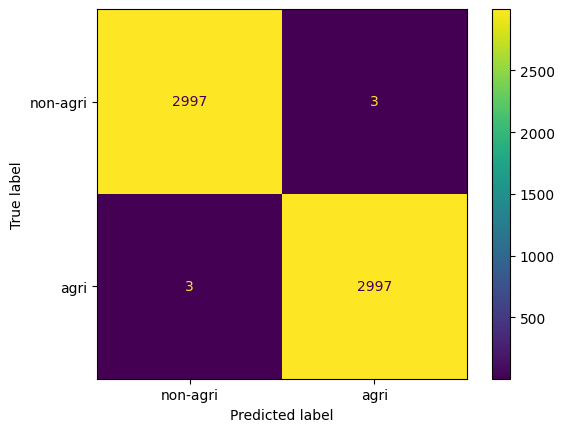

In [21]:
## Please use the space below to write your answer
print_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels, 
    'Pytorch CNN-Vit Hybrid Model'
)